In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from ipywidgets import *
import scipy.stats as sstats 
from scipy.stats import gaussian_kde as gkde

### Define plotting functions

In [ ]:
def comparepush(x, obs_dens, post_dens):
    plt.plot(x, obs_dens.pdf(x.transpose()), 'y', label='obs')
    plt.plot(x, post_dens.evaluate(x), 'c', label='Q(post)')
    plt.xlabel('$Q(\lambda)$')
    plt.legend()
    plt.show()

def compare_input_dens(x, analytical_dens, estimated_dens, viewdim=0, lab_1='prior', lab_2='KDE prior', title=''):
    # specify viewdim (list) to view crosssections e.g. [0,1] gives you the diagonal view through the first two dimensions
    input_dim = estimated_dens.d
    num_samples = len(x)
    y = np.zeros( (input_dim, num_samples) )
    y[viewdim,:] = x 
    plt.plot(x, analytical_dens.pdf( y.transpose() ), 'y', label=lab_1)
    plt.plot(x, estimated_dens.evaluate(y), 'c', label=lab_2)
    if type(viewdim) == int:
        plt.xlabel('$\lambda_%d$'%viewdim)
    else:
        plt.xlabel('$\lambda_{%s}$'%str(viewdim))
    plt.title(title)
    plt.legend()
    plt.show()
    
def compare_output_dens(x, analytical_dens, estimated_dens, viewdim=0, lab_1='observed', lab_2='KDE push', title=''):
    # specify viewdim (list) to view crosssections e.g. [0,1] gives you the diagonal view through the first two dimensions
    input_dim = estimated_dens.d
    num_samples = len(x)
    y = np.zeros( (input_dim, num_samples) )
    y[viewdim,:] = x 
    plt.plot(x, analytical_dens.pdf( y.transpose() ), 'y', label=lab_1)
    plt.plot(x, estimated_dens.evaluate(y), 'c', label=lab_2)
    if type(viewdim) == int:
        plt.xlabel('$Q(\lambda_%d)$'%viewdim)
    else:
        plt.xlabel('$Q(\lambda_{%s})$'%str(viewdim))
    plt.title(title)
    plt.legend()
    plt.show()

def compare_est_input_dens(x, estimated_dens1, estimated_dens2, viewdim=0, lab_1='KDE prior', lab_2='KDE post', title=''):
    input_dim = estimated_dens1.d
    num_samples = len(x)
    y = np.zeros( (input_dim, num_samples) )
    y[viewdim,:] = x # specify dim (list) to view crosssections e.g. [0,1] gives you the diagonal view through the first two dimensions
    plt.plot(x, estimated_dens1.evaluate(y), 'y', label=lab_1)
    plt.plot(x, estimated_dens2.evaluate(y), 'c', label=lab_2)
    if type(viewdim)==int:
        plt.xlabel('$\lambda_%d$'%viewdim)
    else:
        plt.xlabel('$\lambda_{%s}$'%str(viewdim))
    plt.title(title)
    plt.legend()
    plt.show()
    
def pltaccept(lam, lam_accept, N, i=0, j=1): # plots first N of accepted, any 2D marginals specified
    plt.scatter(lam[i,:], lam[j,:], s=2)
    plt.scatter(lam_accept[i,0:N], lam_accept[j,0:N], s=4)
    plt.xlabel('$\lambda_%d$'%i)
    plt.ylabel('$\lambda_%d$'%j)
    plt.show()

## Sample from $\Lambda$

In [ ]:
num_samples = int(1E4)
input_dim = 1
lam = 2*np.random.uniform( size = (input_dim, num_samples) ) # standard uniform
x = np.linspace(0, 2, 100) # for plotting purposes

Consider the ODE IVP
$$
\partial_t u(t) = -u(t) \\
u(0) = \lambda_0
$$

The solution to this problem is $u(t) = \lambda_0 e^{-t}$.

Suppose $\lambda_0$ is our true reference parameter and that we are trying to estimate this parameter through experiments. Suppose we know that $\lambda_0 \in [-1, 1]$ with uniform probability. Suppose we measure the solution at K evenly spaced intervals in [0, T]. 

We want to transform these measurements into a single measurement, which we do by looking at the MSE (2-norm) between the observations and the model predictions.  
$$
Q(\lambda) = \frac{1}{K} \sum_{k=1}^{K} (\lambda e^{-\frac{Tk}{K}} - \lambda_0e^{-\frac{Tk}{K}}) ^ 2 / \sigma_k^2 = \frac{1}{K}  \sum_{k=1}^{K} \frac{( (\lambda- \lambda_0) e^{-\frac{Tk}{K}} ) ^ 2 }{ \sigma_k^2}
$$

In [ ]:
num_times = 3 # measurement frequency (K)
T_min, T_max = 0.1, 1 #  max time
lam0 = 0.5 # true / reference lambda_0
sd = 1 # STANDARD DEVIATION FOR EACH MEASUREMENT. this makes it constant for all of them.
sigma = sd*np.ones(num_times)
t = np.linspace(T_min,T_max,num_times)
print t
def QoI_fun(lam):
    return (1./num_times)*np.sum([np.power([ ((lam - lam0)*np.exp(-t[1]*T_max/num_times))/sigma[1] ],2)[0] for k in range(1,num_times+1)],0)

# def QoI_funf(lam):
#     lam0 = 0 # true / reference lambda_0
#     num_times = 10
#     return np.power([lam*np.exp(t) - lam0*np.exp(t)],2)[0] for t in range(1,num_times+1)],0)

---
## Compute QoI vector

Format: `(n_dims, n_samples)`  
_Optional_: Specify subset of QoI's to use for inversion using variable `QoI_indices` 

In [ ]:
q_full = QoI_fun(lam)
QoI_indices = None
if QoI_indices is not None:
    q = q_full[QoI_indices,:]
else:
    q = q_full
        
print('dimensions :  lambda = '+str(lam.shape)+'   q = '+str(q.shape)+'   q_full = '+str(q_full.shape) )

In [ ]:
q

In [ ]:
np.min(q[0])

In [ ]:
plt.hist(q[0],100)
plt.title('histogram of data space')
# plt.xlim([0,100])
plt.show()

## Define observed density

In [ ]:
# var_const = .1
output_dim = q.shape[0]

# Interesting things happen with time series data that uses uniform on output.
uni_max = 0.01
# obs_dens = sstats.uniform(0,uni_max) # 1D only
# obs_dens = sstats.norm(0.5,sigma) # 1D only
# But if the errors are normally distributed, the observed density will by a chi^2 of order K.
print num_times
obs_dens = sstats.chi2(num_times)
xx = np.linspace(0,20,100)
plt.plot(xx,obs_dens.pdf(xx)) # CHI SQUARED
# plt.plot(xx,np.divide(1,obs_dens.pdf(xx))) # RECIPRICAL CHI SQUARED

# TODO: add support for multivariate uniforms. 

# obs_dens = sstats.multivariate_normal(mean = np.zeros(output_dim), 
#                                       cov = var_const*np.eye(output_dim) )

In [ ]:
# for d_dim in range(1,21):
#     d = sstats.multivariate_normal(mean = np.zeros(d_dim), cov = np.eye(d_dim))
#     print '%2.2e'%d.pdf(np.zeros(d_dim))

In [ ]:
np.max(q[0])
num_times


## Compute push-forward of the prior

In [ ]:
pf_dens = gkde(q[0])

In [ ]:
x = np.linspace(0,1.1*np.max(q[0]),100)
plt.plot(x,pf_dens.evaluate(x))

## Accept/reject sampling of posterior
(samples come from prior that was used to compute the pushforward)

In [ ]:
lam_accept = []
# r = (1./obs_dens.pdf( q )) / pf_dens.evaluate(q) # RECIPRICAL CHI SQUARED. REGULAR IS BELOW.
r = obs_dens.pdf( q ) / pf_dens.evaluate(q) # vector of ratios evaluated at all the q(lambda)'s
M = np.max(r)
eta_r = r[0]/M

In [ ]:
for i in range(num_samples):
    xi = np.random.uniform(0,1)
    if eta_r[i] > xi:
        lam_accept.append( lam[:,i] )

lam_accept = np.array( lam_accept[1::] ).transpose()
num_accept = lam_accept.shape[1]
print('Number accepted: %d = %2.2f%%'%(num_accept, 100*np.float(num_accept)/num_samples))

In [ ]:
np.sum(r)

In [ ]:
plt.scatter(lam,eta_r)
plt.scatter([lam0],0.05)
# plt.xlim([0.05-0.01, 0.05+0.01])

In [ ]:
# interact(pltaccept, lam = fixed(lam), lam_accept = fixed(lam_accept), 
#          N = (1, num_accept, 10), i = (0, input_dim-1, 1), j = (0, input_dim-1, 1))


## All in one

Computing QoI
Summary of dimensions :  lambda = (1, 10000)   q = (1, 10000)   q_full = (1, 10000)
Defining Observed Density with bound 1.00e-01
Computing weights


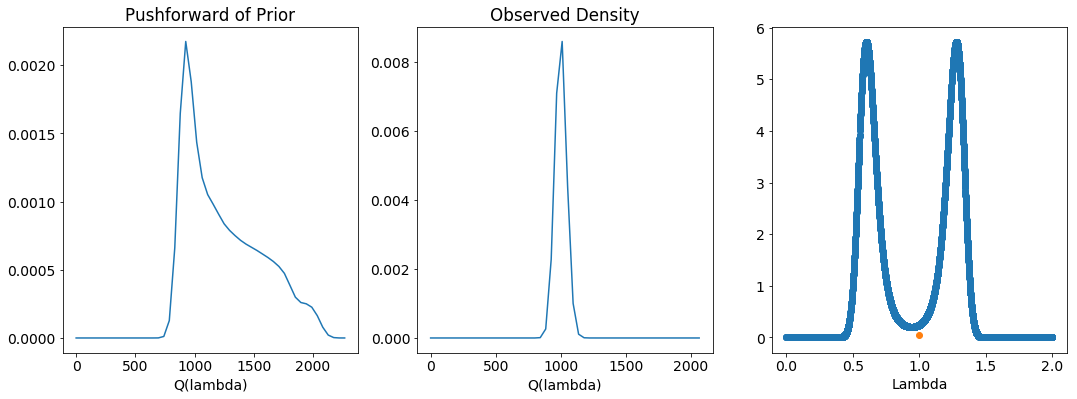

In [133]:
num_samples = int(1E4)
num_times = 1000 # measurement frequency (K)
# number of model solves = num_samples*num_times. dim_qoi = 1 because we are assimilating measurements into a single QoI
T_min, T_max = 0.1, 10 #  max time
# uni_max = 1E-3
lam0 = 1 # true / reference lambda_0
sd = 0.2 # STANDARD DEVIATION FOR EACH MEASUREMENT. this makes it constant for all of them.

############################
input_dim = 1
lam = 2*np.random.uniform( size = (input_dim, num_samples) ) # standard uniform PRIOR
x = np.linspace(0, 2, 100) # for plotting purposes

sigma = sd*np.ones(num_times+1)
t = np.linspace(T_min,T_max,num_times) # INCLUDES T_min - Useful if you want to be very specific about start-time
# t = np.linspace(T_min,T_max,num_times+1)[1::] # EXCLUDES T_min - Useful if you want to keep T_min at 0
# print t
def data(lam):
    noise = 1 # noise on or off
    return lam0*np.exp(-t) + noise*sd*np.random.randn(1,num_times)
d = data(lam) # make random data. fix it.

def QoI_fun(d,lam):
    noise = 0 # stochastic map or no? treating model like best unbiased predictor
    return (1./1)*np.sum([np.power([ ( lam*np.exp(-t[k]) + noise*sd*np.random.randn(1,num_samples)
                                      - d[0,k])/sigma[k] ],2)[0] for k in range(num_times)],0)

print('Computing QoI')
q_full = QoI_fun(d,lam)
QoI_indices = None
if QoI_indices is not None:
    q = q_full[QoI_indices,:]
else:
    q = q_full
        
print('Summary of dimensions :  lambda = '+str(lam.shape)+'   q = '+str(q.shape)+'   q_full = '+str(q_full.shape) )
print('Defining Observed Density with bound %2.2e'%(uni_max))
# obs_dens = sstats.uniform(0,uni_max) # 1D only
obs_dens = sstats.chi2(num_times)

pf_dens = gkde(q[0])
lam_accept = []
# r = (1./obs_dens.pdf( q )) / pf_dens.evaluate(q) # RECIPRICAL CHI SQUARED. REGULAR IS BELOW.
print('Computing weights')
r = obs_dens.pdf( q ) / pf_dens.evaluate(q) # vector of ratios evaluated at all the q(lambda)'s
M = np.max(r)
eta_r = r[0]
inds = []
##### OPTIONAL - RUN ACCEPT/REJECT
# print('Performing accept/reject')
# for i in range(num_samples):
#     xi = np.random.uniform(0,1)
#     if eta_r[i] > xi:
#         lam_accept.append( lam[:,i] )
#         inds.append(i)

# lam_accept = np.array( lam_accept[1::] ).transpose()
# num_accept = lam_accept.shape[1]
# print('Number accepted: %d = %2.2f%%'%(num_accept, 100*np.float(num_accept)/num_samples))
######

plt.rcParams['figure.figsize'] = (18, 6)
plt.figure()
plt.subplot(1, 3, 3)
plt.scatter(lam,eta_r)
# plt.plot(lam_accept, gkde(lam_accept))
plt.scatter(lam0,0.05)
# plt.title('Posterior Distribution\nof Uniform Observed Density \nwith bound = %1.2e'%uni_max)
plt.xlabel('Lambda')
pr = 0.2
# plt.xlim(lam0*np.array([1-pr,1+pr]))

plt.subplot(1, 3, 1)
x = np.linspace(0,1.1*np.max(q[0]),50)
plt.plot(x,pf_dens.evaluate(x))
plt.title('Pushforward of Prior')
plt.xlabel('Q(lambda)')

plt.subplot(1, 3, 2)
# xx = np.linspace(0,2*uni_max,50)
xx = np.linspace(0,np.max(q[0]),50)
plt.plot(xx,obs_dens.pdf(xx))
plt.title('Observed Density')
plt.xlabel('Q(lambda)')

plt.show()

In [15]:
# np.exp(t[0])*lam - d[0,1]

In [23]:
lam.shape

(1, 1000)

---
## Visualize Posterior Density

In [ ]:
prior_dens_kde = gkde(lam)
post_dens_kde = gkde(lam_accept) # Not very useful
# Can plot "slices" of densities to observe differences between posterior and prior, but not that useful
interact(compare_est_input_dens, x = fixed(x), 
         estimated_dens1 = fixed(prior_dens_kde), estimated_dens2 = fixed(post_dens_kde), 
         lab_1 = fixed('KDE prior'), lab_2 = fixed('KDE post'), title=fixed(''),
         viewdim=(0, input_dim-1, 1))


In [ ]:
prior_dens = sstats.multivariate_normal( mean = np.zeros(5), cov = np.eye(5) ) # Exact density
interact(compare_input_dens, x = fixed(x), 
         analytical_dens = fixed(prior_dens), estimated_dens = fixed(post_dens_kde), 
         lab_1 = fixed('prior'), lab_2 = fixed('KDE post'), title = fixed(''),
         viewdim = (0, input_dim-1, 1))

## Construct the push-forward of the posterior using accepted samples

In [ ]:
x = np.linspace(-1,1, 100)
# x = np.tile(np.linspace(-5,5,100),[output_dim,1])
push_post_dens_kde = gkde( QoI_fun(lam_accept) )
# Plot the push-forward of the posterior, should look like the observed density
# interact(compare_output_dens, x = fixed(x), 
#          analytical_dens = fixed(obs_dens), estimated_dens = fixed(push_post_dens_kde), 
#          lab_1 = fixed('observed'), lab_2 = fixed('KDE push'), title = fixed(''),
#          viewdim = (0, output_dim-1, 1))
compare_output_dens(x,obs_dens, push_post_dens_kde)

In [ ]:
# diagonal crossection view
compare_output_dens(x, obs_dens, push_post_dens_kde, 
                    viewdim = range(output_dim), title = 'Diagonal Cross-Section')

---
## Extra visualizations

### Create KDE of samples on $\Lambda$ or use specified density on $\Lambda$

***The KDE is not necessary if the density on the input space is already specified***

Here, we just do this to show how the density estimator works compared to the exact density.

The KDE is not necessary except for the push-forward density. 

### Compare KDE of prior to the actual prior

In [ ]:
interact(compare_input_dens, x = fixed(x), 
         analytical_dens = fixed(prior_dens), estimated_dens = fixed(prior_dens_kde),
         lab_1 = fixed('prior'), lab_2 = fixed('KDE prior'), title = fixed(''),
         viewdim = (0, input_dim-1, 1))

In [ ]:
# diagonal crossection view
compare_input_dens(x, prior_dens, prior_dens_kde, 
                   viewdim = range(input_dim), title = 'Diagonal Cross-Section')